# CS Subfield Classifier using SPECTER + XGBoost

This notebook builds a subfield classifier for Computer Science research papers using:
- SPECTER embeddings (from Title + Abstract)
- XGBoost for classification
- LabelEncoder for encoding subfields

Target: Achieve ≥90% classification accuracy across subfields like AI, CV, etc.

In [1]:
import sentence_transformers
import xgboost
import sklearn
import joblib

print("All packages are already installed and ready ✅")

All packages are already installed and ready ✅


## 1. Load and Prepare CS Subfield Dataset

We load the `CS_subfields.csv` file from the `Data/` directory. Each row contains:

- **Title**: Research paper title
- **Abstract**: Paper abstract
- **Subfield**: CS subfield label (e.g., AI, CV, NLP, CV, SE, etc.)
- **Link**: Source URL for the paper

We also concatenate the Title and Abstract into a new `input_text` column, which will be used for generating SPECTER embeddings.

In [2]:
import pandas as pd

# Step 1: Load dataset
df = pd.read_csv("Data/CS_subfields.csv")

# Create input_text for embedding
df["input_text"] = df["Title"].astype(str).str.strip() + " " + df["Abstract"].astype(str).str.strip()

# Show shape and preview only the 4 relevant columns
print(df.shape)
df[["Title", "Abstract", "Subfield", "Link"]].head()

(1498, 5)


,Title,Abstract,Subfield,Link
0,Beyond Frameworks: Unpacking Collaboration Str...,Multi-agent collaboration has emerged as a piv...,AI,http://arxiv.org/abs/2505.12467v1
1,Any-to-Any Learning in Computational Pathology...,Recent advances in computational pathology and...,AI,http://arxiv.org/abs/2505.12711v1
2,AutoMat: Enabling Automated Crystal Structure ...,Machine learning-based interatomic potentials ...,AI,http://arxiv.org/abs/2505.12650v1
3,ACU: Analytic Continual Unlearning for Efficie...,The development of artificial intelligence dem...,AI,http://arxiv.org/abs/2505.12239v1
4,Empowering Sustainable Finance with Artificial...,This chapter explores the convergence of two m...,AI,http://arxiv.org/abs/2505.12012v1


In [3]:
# Preview the constructed input_text
df["input_text"].head()

0    Beyond Frameworks: Unpacking Collaboration Str...
1    Any-to-Any Learning in Computational Pathology...
2    AutoMat: Enabling Automated Crystal Structure ...
3    ACU: Analytic Continual Unlearning for Efficie...
4    Empowering Sustainable Finance with Artificial...
Name: input_text, dtype: object

## 2. Check Subfield Distribution and Encode Labels

We inspect the number of papers per subfield to detect any class imbalance.  
Next, we use `LabelEncoder` to convert subfield labels into numerical format required for model training.

In [4]:
from collections import Counter

# Check class distribution
subfield_counts = Counter(df["Subfield"])
print("Subfield Distribution:\n")
for subfield, count in subfield_counts.items():
    print(f"{subfield}: {count}")

Subfield Distribution:

AI: 300
ML: 300
CV: 298
CYB: 300
PAST: 300


In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode subfield labels
le = LabelEncoder()
df["subfield_label"] = le.fit_transform(df["Subfield"])

# Preview encoded labels
df[["Subfield", "subfield_label"]].drop_duplicates().sort_values("subfield_label")

,Subfield,subfield_label
0,AI,0
600,CV,1
898,CYB,2
300,ML,3
1198,PAST,4


## 3. Generate SPECTER Embeddings

We now load the `allenai-specter` model using `sentence-transformers` and generate dense 768-dimensional embeddings for each `input_text`.

These embeddings will be used as features for training the XGBoost classifier.

In [6]:
from sentence_transformers import SentenceTransformer

# Load the pretrained SPECTER model
model = SentenceTransformer("allenai-specter")

# Encode input text (this may take 1–2 minutes)
X_embeddings = model.encode(df["input_text"].tolist(), batch_size=32, show_progress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

## 4. Train-Test Split

We split the dataset into training and test sets using an 80/20 stratified split.  
This ensures that each subfield is proportionally represented in both sets.

In [7]:
from sklearn.model_selection import train_test_split

# Define features and labels
X = X_embeddings
y = df["subfield_label"].values

# 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 1198, Test size: 300


## 5. Train XGBoost Classifier

We now train an `XGBClassifier` on the SPECTER embeddings.  
This model uses default hyperparameters and will serve as our baseline.

In [8]:
from xgboost import XGBClassifier

# Initialize classifier
xgb = XGBClassifier(
    use_label_encoder=False,  # disables legacy label encoding warning
    eval_metric='mlogloss',   # multiclass log-loss
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)

/opt/anaconda3/envs/nlp-bert/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## 6. Evaluate Model Performance

We evaluate the classifier on the test set using:
- Accuracy
- Precision, Recall, and F1-score (per class)
- Confusion Matrix

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = xgb.predict(X_test)

# Decode labels for readability
label_names = le.classes_

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_names))

# Show raw confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

          AI       0.68      0.50      0.58        60
          CV       0.79      0.92      0.85        60
         CYB       0.80      0.87      0.83        60
          ML       0.68      0.63      0.66        60
        PAST       0.83      0.90      0.86        60

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.75       300
weighted avg       0.76      0.76      0.75       300

Confusion Matrix:

[[30  9  4 13  4]
 [ 1 55  0  4  0]
 [ 4  0 52  0  4]
 [ 6  5  8 38  3]
 [ 3  1  1  1 54]]


## 7. Save Model Artefacts

We save the trained XGBoost model and label encoder using `joblib`.  
This allows us to reuse the classifier later without retraining.

In [10]:
import joblib
import os

# Save model and label encoder
joblib.dump(xgb, "Artefacts/cs_subfield_xgb_model_v2.3.pkl")
joblib.dump(le, "Artefacts/cs_subfield_label_encoder_v2.3.pkl")

print("Saved model and label encoder to Artefacts folder ✅")

Saved model and label encoder to Artefacts folder ✅


### Classification Results Summary (v2.3 – SPECTER + XGBoost)

The classifier achieved the following evaluation metrics on the test set:

- **Accuracy**: 76%
- **Macro F1-score**: 0.75
- **Weighted F1-score**: 0.75

#### 🔍 Per-Class F1 Scores:
| Subfield | F1 Score | Comments |
|----------|----------|----------|
| **AI**   | 0.58     | Significantly lower than others; likely due to semantic overlap with ML and NLP |
| **CV**   | 0.85     | Very strong; likely benefits from unique vocabulary (e.g., image, detection) |
| **CYB**  | 0.83     | High performance; less lexical ambiguity |
| **ML**   | 0.66     | Moderate; some confusion with AI and CV |
| **PAST** | 0.86     | Highest performer; domain-specific terms help differentiate |

The results suggest that **SPECTER embeddings combined with XGBoost** work well for clearly distinguishable subfields like **CV, CYB, and PAST**, but struggle slightly with more **overlapping areas like AI and ML**.

Confusion is especially observed between **AI and ML**, which share significant conceptual and lexical similarity. Further tuning or a hierarchical refinement may be needed to better disambiguate these.

We now visualize the confusion matrix to examine these patterns more closely.

### Confusion Matrix (Heatmap)

We plot the confusion matrix as a heatmap to visualize where the model is confusing between subfields.

Darker diagonal = better performance. Off-diagonal values indicate misclassifications.

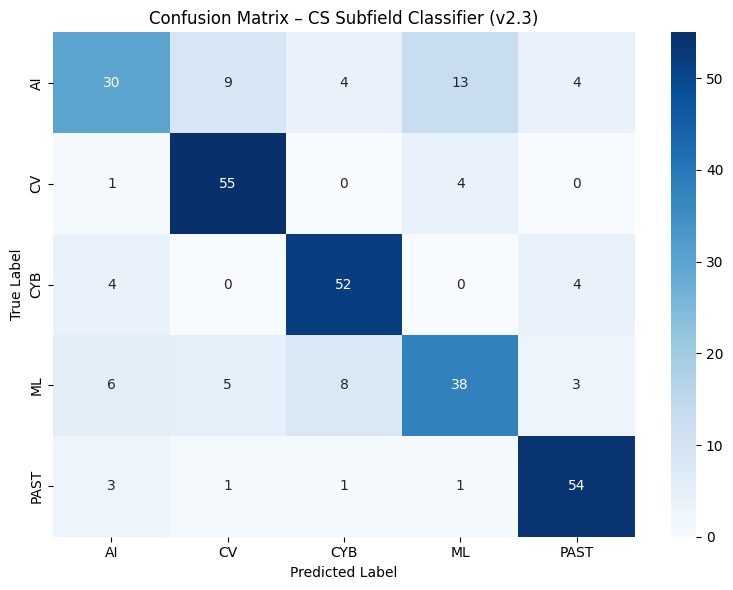

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – CS Subfield Classifier (v2.3)")
plt.tight_layout()
plt.show()